In [1]:
import yaml
import pandas as pd
import numpy as np
from pathlib import Path
import os

# ==============================================================================
# 1. CARGA DE CONFIGURAÇÃO
# ==============================================================================

def find_project_root(anchor_file="conf/config.yaml"):
    """
    Sobe os diretórios a partir do notebook atual até encontrar
    a pasta onde 'conf/config.yaml' existe.
    """
    current_path = Path.cwd()
    
    # Tenta no diretório atual e sobe até o raiz do sistema
    for parent in [current_path] + list(current_path.parents):
        potential_config = parent / anchor_file
        if potential_config.exists():
            return parent
            
    raise FileNotFoundError(f"Não foi possível encontrar a raiz do projeto contendo '{anchor_file}'.")

# 1. Definir BASE_DIR (Raiz do Projeto)
try:
    BASE_DIR = find_project_root("conf/config.yaml")
    print(f"📂 Raiz do Projeto encontrada: {BASE_DIR}")
except FileNotFoundError as e:
    # Fallback manual caso a busca automática falhe (ajuste se necessário)
    print("Busca automática falhou. Usando fallback.")
    BASE_DIR = Path("/Users/lucasborges/Downloads/TCC")

# 2. Carregar o YAML da pasta conf
CONFIG_PATH = BASE_DIR / "conf/config.yaml"
with open(CONFIG_PATH, "r") as f:
    config = yaml.safe_load(f)

# ==============================================================================
# 2. ATALHOS E VARIÁVEIS GLOBAIS
# ==============================================================================

# Atalhos dos Dicionários do YAML
# P['raw'] vai virar algo como: /Users/.../TCC/data/raw
P = {k: BASE_DIR / v for k, v in config['paths'].items()} # P de Paths
F = config['files']                                       # F de Files
PM = config['params']                                     # PM de Params

print(f"⚙️ Configuração carregada de: {CONFIG_PATH}")

# ==============================================================================
# 3. PONTE DE VARIÁVEIS
# ==============================================================================

# Caminhos de Arquivos (Apontando para o YAML)
TRAIN_EMB_PATH       = P['processed'] / F['track_embeddings']
NEW_EMB_PATH         = P['processed'] / F['new_track_embeddings']
X_TRAIN_PATH         = P['processed'] / F['train_features']
X_TEST_PATH          = P['processed'] / F['test_features']


# Caminhos de Grafos
# Verifica se as chaves existem no yaml, senão usa padrão
MATCHING_MAP_PATH    = P.get('graphs_coarsened', P['graphs_bipartite']) / F['matching_map']
SUPER_EMB_PATH       = P.get('graphs_super', P['graphs_bipartite'])     / F['super_embeddings']

# Parâmetros
SEED                 = PM['seed']

# Configurações Visuais Padrão
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")
plt.rcParams['figure.dpi'] = 300

📂 Raiz do Projeto encontrada: /Users/lucasborges/Downloads/TCC
⚙️ Configuração carregada de: /Users/lucasborges/Downloads/TCC/conf/config.yaml


In [2]:
df_playlists       = pd.read_parquet(P['raw'] / "df_playlists_v0.parquet")
df_tracks          = pd.read_parquet(P['raw'] / "df_tracks_v0.parquet")
df_features        = pd.read_parquet(P['raw'] / "features_checkpoint.parquet")
dim_artists        = pd.read_parquet(P['raw'] / "dim_artists.parquet")
dim_albums         = pd.read_parquet(P['raw'] / "dim_albums.parquet")
df_tracks_complete = pd.read_parquet(P['raw'] / "df_tracks_complete.parquet")

print("Tudo carregado!")

Tudo carregado!


In [3]:

import pandas as pd
import numpy as np
import re
from typing import List, Dict, Any
import matplotlib.pyplot as plt
import seaborn as sns
import gc
from cycler import cycler

def set_academic_style():
    # 1. Paleta de Cores Minimalista (Soft & Professional)
    # Azul Slate, Verde Sálvia, Rosa Antigo, Cinza Quente, Roxo Lavanda
    colors = ["#1DB954", "#7DAA92", "#C96868", "#8D99AE", "#8F8389"]
    
    # Cores semânticas (para usar manualmente quando precisar destacar algo)
    global C_PRIMARY, C_HIGHLIGHT, C_NEUTRAL, C_ACCENT
    C_PRIMARY = colors[0]    # Dados principais
    C_HIGHLIGHT = colors[2]  # Destaque/Erro/Atenção (ex: linha vertical)
    C_NEUTRAL = "#2C3E50"    # Textos e linhas de base
    C_ACCENT = colors[1]     # Comparação positiva
    
    # 2. Configurações Globais do Matplotlib (rcParams)
    plt.rcParams.update({
        # Fontes
        "font.family": "sans-serif",
        "font.sans-serif": ["Arial", "DejaVu Sans", "Liberation Sans"],
        "font.size": 11,
        "axes.titlesize": 13,
        "axes.labelsize": 11,
        
        # Cores e Linhas
        "axes.prop_cycle": cycler('color', colors),
        "lines.linewidth": 2,
        "lines.markersize": 6,
        "axes.spines.top": False,    # Remove borda superior (Minimalismo)
        "axes.spines.right": False,  # Remove borda direita (Minimalismo)
        
        # Grid (suave e apenas horizontal geralmente ajuda a leitura)
        "axes.grid": True,
        "grid.alpha": 0.3,
        "grid.linestyle": "--",
        "grid.color": "#b0b0b0",
        
        # Cores de eixos
        "axes.edgecolor": "#505050",
        "xtick.color": "#505050",
        "ytick.color": "#505050",
        "text.color": "#303030",
        
        # Figura
        "figure.facecolor": "white",
        "axes.facecolor": "white",
        "figure.dpi": 150 # Melhor resolução para visualizar no notebook
    })
    
    # Configuração do Seaborn para harmonizar
    sns.set_context("paper", font_scale=1.2)
    sns.set_style("ticks", {"axes.grid": True, "grid.linestyle": "--"})
    sns.set_palette(colors)

# Execute a função
set_academic_style()

## Redundâncias

In [4]:
df_tracks_complete[["track_spotify_id", "track_uri", "reccobeats_id", "spotify_href"]].nunique()

track_spotify_id    679889
track_uri           679889
reccobeats_id       387280
spotify_href        387280
dtype: int64

In [5]:
#Remoção de tracks cujas audio features não foram encontradas na API ReccoBeats
df_tracks_complete_v1 = df_tracks_complete[df_tracks_complete["spotify_href"].notna()]

df_tracks_complete_v1[["track_spotify_id", "track_uri", "reccobeats_id", "spotify_href"]].nunique()

track_spotify_id    387280
track_uri           387280
reccobeats_id       387280
spotify_href        387280
dtype: int64

In [6]:
# Remoção de colunas "iguais"
ids_spotify = ["track_spotify_id", "reccobeats_id", "spotify_href", "artist_spotify_id", "album_spotify_id"]
df_tracks_complete_v1 = df_tracks_complete_v1.drop(ids_spotify, axis=1)

In [7]:
df_tracks_complete_v1.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3691508 entries, 0 to 6685100
Data columns (total 29 columns):
 #   Column                  Dtype  
---  ------                  -----  
 0   track_uri               object 
 1   track_name              object 
 2   artist_uri              object 
 3   artist_name             object 
 4   album_uri               object 
 5   album_name              object 
 6   duration_ms             int64  
 7   pos                     int64  
 8   pid                     int64  
 9   acousticness            float32
 10  danceability            float32
 11  energy                  float32
 12  instrumentalness        float32
 13  liveness                float32
 14  loudness                float32
 15  speechiness             float32
 16  tempo                   float32
 17  valence                 float32
 18  key                     Int8   
 19  mode                    Int8   
 20  artist_followers        Int64  
 21  artist_popularity       Int16  
 22 

In [8]:
# Análise de valores duplicados (verifica se há músicas repetidas na mesma playlist)
duplicates = df_tracks_complete_v1.duplicated(subset=['pid', 'track_uri'], keep=False)

print(f"Total de linhas duplicadas (mesma música na mesma playlist): {duplicates.sum()}")
print(f"Percentual de duplicatas: {(duplicates.sum() / len(df_tracks_complete_v1)) * 100:.2f}%")

# Mostrar algumas duplicatas se existirem
if duplicates.any():
    print("\nExemplo de duplicatas encontradas:")
    display(df_tracks_complete_v1[duplicates].head(10))

Total de linhas duplicadas (mesma música na mesma playlist): 93038
Percentual de duplicatas: 2.52%

Exemplo de duplicatas encontradas:


,track_uri,track_name,artist_uri,artist_name,album_uri,album_name,duration_ms,pos,pid,acousticness,...,mode,artist_followers,artist_popularity,artist_genres,release_date,release_date_precision,album_type,total_tracks,label,album_popularity
31,spotify:track:6GIrIt2M39wEGwjCQjGChX,The Great Escape,spotify:artist:0vWCyXMrrvMlCcepuOJaGI,Boys Like Girls,spotify:album:4WqgusSAgXkrjbXzqdBY68,Boys Like Girls,206520,31,0,0.001660,...,0,1278753,64,"[pop punk, emo]",2007-08-31,day,album,12,Columbia,54
51,spotify:track:6GIrIt2M39wEGwjCQjGChX,The Great Escape,spotify:artist:0vWCyXMrrvMlCcepuOJaGI,Boys Like Girls,spotify:album:4WqgusSAgXkrjbXzqdBY68,Boys Like Girls,206520,51,0,0.001660,...,0,1278753,64,"[pop punk, emo]",2007-08-31,day,album,12,Columbia,54
313,spotify:track:1dzQoRqT5ucxXVaAhTcT0J,Just Dance,spotify:artist:1HY2Jd0NmPuamShAr6KMms,Lady Gaga,spotify:album:1qwlxZTNLe1jq3b0iidlue,The Fame,241933,15,5,0.026400,...,0,41496744,93,"[art pop, pop]",2008-01-01,day,album,15,Streamline/Interscope,80
316,spotify:track:1dzQoRqT5ucxXVaAhTcT0J,Just Dance,spotify:artist:1HY2Jd0NmPuamShAr6KMms,Lady Gaga,spotify:album:1qwlxZTNLe1jq3b0iidlue,The Fame,241933,18,5,0.026400,...,0,41496744,93,"[art pop, pop]",2008-01-01,day,album,15,Streamline/Interscope,80
493,spotify:track:6uvT4Di9ZRBw5cbexZJDts,Highwayman,spotify:artist:5W5bDNCqJ1jbCgTxDD0Cb3,Willie Nelson,spotify:album:3DDUesugWE5mJjTF5HFsRg,Nashville Rebel,182973,0,9,0.541000,...,0,2551744,73,"[outlaw country, classic country, country, tra...",2006-09-26,day,album,92,RLG/Legacy,54
494,spotify:track:6uvT4Di9ZRBw5cbexZJDts,Highwayman,spotify:artist:5W5bDNCqJ1jbCgTxDD0Cb3,Willie Nelson,spotify:album:3DDUesugWE5mJjTF5HFsRg,Nashville Rebel,182973,1,9,0.541000,...,0,2551744,73,"[outlaw country, classic country, country, tra...",2006-09-26,day,album,92,RLG/Legacy,54
648,spotify:track:0oIsNC7YcF48ozlsBacKRY,Don't Let Me Down (feat. Cat Martin),spotify:artist:4kjWnaLfIRcLJ1Dy4Wr6tY,Blackmill,spotify:album:2ayhUoOppwZ5paYiXTRqqa,Miracle,407439,62,11,0.002320,...,0,<NA>,<NA>,None,2011-12-21,day,album,11,Blackmill,48
662,spotify:track:0oIsNC7YcF48ozlsBacKRY,Don't Let Me Down (feat. Cat Martin),spotify:artist:4kjWnaLfIRcLJ1Dy4Wr6tY,Blackmill,spotify:album:2ayhUoOppwZ5paYiXTRqqa,Miracle,407439,76,11,0.002320,...,0,<NA>,<NA>,None,2011-12-21,day,album,11,Blackmill,48
749,spotify:track:0ttHpMs250dpFkCYAnuhnE,Good,spotify:artist:4UuoJfJ9UybJft7a8E6UHX,Better Than Ezra,spotify:album:0c8yj78CBgDsEvq9pzudIS,Deluxe,185093,7,14,0.000372,...,1,459372,53,[],1995-02-28,day,album,13,Elektra Records,52
843,spotify:track:0ttHpMs250dpFkCYAnuhnE,Good,spotify:artist:4UuoJfJ9UybJft7a8E6UHX,Better Than Ezra,spotify:album:0c8yj78CBgDsEvq9pzudIS,Deluxe,185093,101,14,0.000372,...,1,459372,53,[],1995-02-28,day,album,13,Elektra Records,52


In [9]:
# Remover duplicatas mantendo a primeira ocorrência
df_tracks_complete_v2 = df_tracks_complete_v1.drop_duplicates(subset=['pid', 'track_uri'], keep='first')

print(f"DataFrame original: {len(df_tracks_complete_v1)} linhas")
print(f"DataFrame sem duplicatas: {len(df_tracks_complete_v2)} linhas")
print(f"Linhas removidas: {len(df_tracks_complete_v1) - len(df_tracks_complete_v2)}")

DataFrame original: 3691508 linhas
DataFrame sem duplicatas: 3643562 linhas
Linhas removidas: 47946


In [10]:
df_tracks_complete_v2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3643562 entries, 0 to 6685100
Data columns (total 29 columns):
 #   Column                  Dtype  
---  ------                  -----  
 0   track_uri               object 
 1   track_name              object 
 2   artist_uri              object 
 3   artist_name             object 
 4   album_uri               object 
 5   album_name              object 
 6   duration_ms             int64  
 7   pos                     int64  
 8   pid                     int64  
 9   acousticness            float32
 10  danceability            float32
 11  energy                  float32
 12  instrumentalness        float32
 13  liveness                float32
 14  loudness                float32
 15  speechiness             float32
 16  tempo                   float32
 17  valence                 float32
 18  key                     Int8   
 19  mode                    Int8   
 20  artist_followers        Int64  
 21  artist_popularity       Int16  
 22 

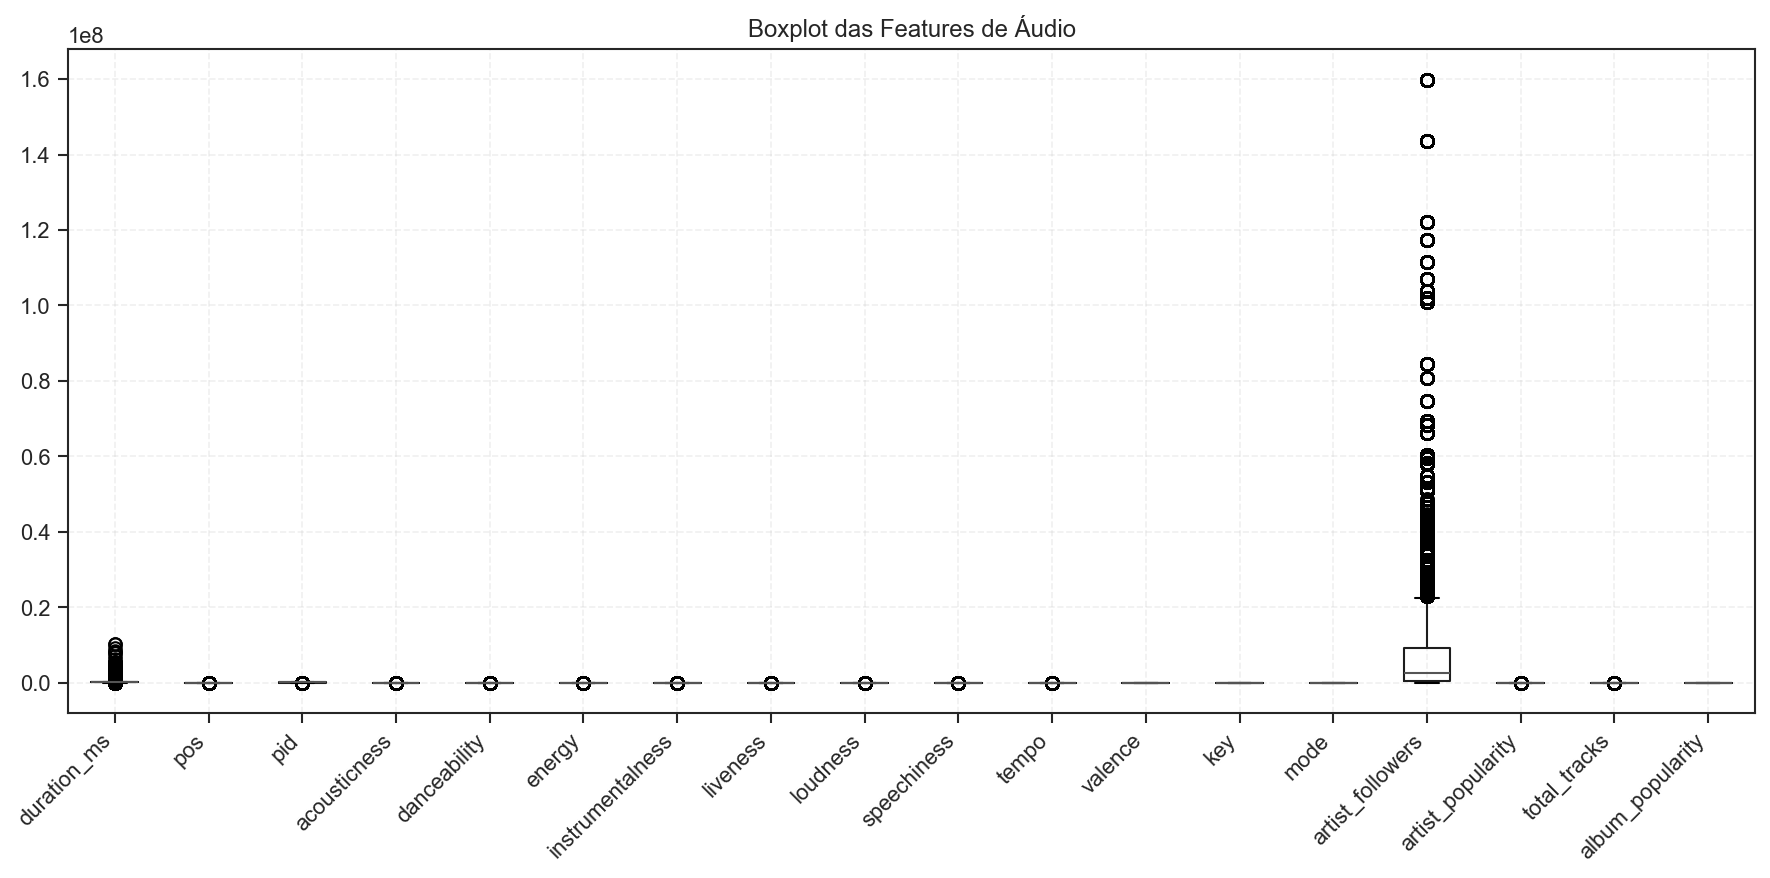

In [11]:
plt.figure(figsize=(12, 6))
df_tracks_complete_v2.boxplot()
plt.title('Boxplot das Features de Áudio')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

## Faltantes

### Conversão numérica

In [12]:
def numeric_conversion(df):
    df_ml = df.copy()
    
    # COLUNAS NUMÉRICAS EXISTENTES → float32
    numeric_to_convert = [
        'duration_ms', 'pos', 'pid', 'acousticness', 'danceability', 
        'energy', 'instrumentalness', 'liveness', 'loudness', 'speechiness',
        'tempo', 'valence', 'key', 'mode', 'artist_followers', 
        'artist_popularity', 'total_tracks', 'album_popularity'
    ]
    
    for col in numeric_to_convert:
        if col in df_ml.columns:
            df_ml[col] = df_ml[col].astype('float32')
    
    # FEATURE ENGINEERING → também em float32
    # Datas
    if 'release_date' in df_ml.columns:
        df_ml['release_date'] = pd.to_datetime(df_ml['release_date'], errors='coerce')
        df_ml['release_year'] = df_ml['release_date'].dt.year.astype('float32')
        df_ml['days_since_release'] = (pd.Timestamp.now() - df_ml['release_date']).dt.days.astype('float32')
    
    return df_ml

In [13]:
# Aplicando 
df_tracks_complete_v3 = numeric_conversion(df_tracks_complete_v2)

In [14]:
df_tracks_complete_v3.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3643562 entries, 0 to 6685100
Data columns (total 31 columns):
 #   Column                  Dtype         
---  ------                  -----         
 0   track_uri               object        
 1   track_name              object        
 2   artist_uri              object        
 3   artist_name             object        
 4   album_uri               object        
 5   album_name              object        
 6   duration_ms             float32       
 7   pos                     float32       
 8   pid                     float32       
 9   acousticness            float32       
 10  danceability            float32       
 11  energy                  float32       
 12  instrumentalness        float32       
 13  liveness                float32       
 14  loudness                float32       
 15  speechiness             float32       
 16  tempo                   float32       
 17  valence                 float32       
 18  key    

In [15]:
# Salvar usando o caminho dinâmico do YAML
save_path = P['interim'] / "df_tracks_complete_v3.parquet"

df_tracks_complete_v3.to_parquet(save_path, index=False)

print(f"Salvo em: {save_path}")

Salvo em: /Users/lucasborges/Downloads/TCC/data/interim/df_tracks_complete_v3.parquet


In [16]:
del df_tracks_complete, df_tracks_complete_v1, df_tracks_complete_v2
gc.collect()

12379

In [17]:
df_tracks_complete_v3.isna().sum()

track_uri                      0
track_name                     0
artist_uri                     0
artist_name                    0
album_uri                      0
album_name                     0
duration_ms                    0
pos                            0
pid                            0
acousticness                 163
danceability                 163
energy                       163
instrumentalness             163
liveness                     163
loudness                     163
speechiness                  163
tempo                        163
valence                      163
key                          163
mode                         163
artist_followers            6829
artist_popularity           6829
artist_genres               6829
release_date              313627
release_date_precision         0
album_type                     0
total_tracks                   0
label                          0
album_popularity               0
release_year              313627
days_since

In [18]:
# Remover linhas com valores faltantes para audio features e artists informations 

cols_remove = [
    "acousticness", "danceability", "energy", "instrumentalness",
    "liveness", "loudness", "speechiness", "tempo", "valence",
    "key", "mode",                       # todas com 163 faltantes
    "artist_followers", "artist_popularity", "artist_genres"  # todas com 6829 faltantes
]

df_tracks_complete_v4 = df_tracks_complete_v3.dropna(subset=cols_remove)

In [19]:
# Salvar usando o caminho dinâmico do YAML
save_path = P['interim'] / "df_tracks_complete_v4.parquet"

df_tracks_complete_v4.to_parquet(save_path, index=False)

print(f"Salvo em: {save_path}")

Salvo em: /Users/lucasborges/Downloads/TCC/data/interim/df_tracks_complete_v4.parquet


In [20]:
del df_tracks_complete_v3
gc.collect()

30

In [21]:
df_tracks_complete_v4.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3636571 entries, 0 to 6685100
Data columns (total 31 columns):
 #   Column                  Dtype         
---  ------                  -----         
 0   track_uri               object        
 1   track_name              object        
 2   artist_uri              object        
 3   artist_name             object        
 4   album_uri               object        
 5   album_name              object        
 6   duration_ms             float32       
 7   pos                     float32       
 8   pid                     float32       
 9   acousticness            float32       
 10  danceability            float32       
 11  energy                  float32       
 12  instrumentalness        float32       
 13  liveness                float32       
 14  loudness                float32       
 15  speechiness             float32       
 16  tempo                   float32       
 17  valence                 float32       
 18  key    

A remoção das tracks sem audio features e artists informations é embasada pela seguinte análise: 

- após a remoção o grafo (música-playlist) ainda é altamente conectado: o maior componente continua cobrindo ~99% dos nós, mesmo após o corte de quase 45% das músicas;
- o número de componentes conectados foi de 78 para 253, refletindo o surgimento de pequenas ilhas isoladas — componentes de 60 a 200 nós (ver no Top-10 tamanho dos componentes conetados);
- a perda de conectividade global é insignificante (≈0,3%): estatisticamente, o grafo manteve sua estrutura principal intacta;
- o dataset reduziu de 1.3 GB para 765.5 MB;
- a limpeza reduziu quase pela metade o volume de dados e corrigiu outliers, mantendo a conectividade global e a coerência estrutural.
- o grafo “limpo” é estatisticamente equivalente ao original para fins de modelagem, mas muito mais saudável para aprendizado e interpretação.

### Visão Macro

| Métrica           | Original | Limpo v0 | Limpo v1 | Dif. percentual (orig → v1) | Interpretação                                                                                      |
| ----------------- | -------- | -------- | -------- | --------------------------- | -------------------------------------------------------------------------------------------------- |
| **Playlists**     | 100.000  | 99.722   | 99.719   | −0.28 %                     | Quase nenhuma playlist perdida.                                                                    |
| **Músicas**       | 679.889  | 387.280  | 384.722  | −43 %                       | Limpeza removeu quase metade das faixas — esperado se foram removidas colunas com nulos e duplicatas. |
| **Arestas (NNZ)** | 6,6 M    | 3,64 M   | 3,63 M   | −45 %                       | Redução proporcional ao número de músicas.                                                         |
| **Densidade**     | 9.70e-5  | 9.43e-5  | 9.48e-5  | ≈ estável                   | Mesmo nível de conectividade relativa entre nós.                                                   |
| **Peso médio**    | 0.1256   | 0.1236   | 0.1236   | −1,6 %                      | Pequeno ajuste, praticamente neutro.                                                               |

### Imputação release_date

In [22]:
def impute_release_info(
    df: pd.DataFrame,
    col_artist: str = "artist_uri",
    ref_ts: pd.Timestamp | None = None,
    stats: dict | None = None, # NOVO: Para evitar vazamento
    verbose: bool = True
) -> pd.DataFrame:
    dfx = df.copy()

    # 0) Preparação de datas
    if ref_ts is None:
        ref_ts = pd.Timestamp.now(tz="UTC").tz_convert(None)
    if ref_ts.tz is not None:
        ref_ts = ref_ts.tz_localize(None)

    if "release_date" in dfx.columns:
        dfx["release_date"] = pd.to_datetime(dfx["release_date"], errors="coerce")
        if dfx["release_date"].dt.tz is not None:
            dfx["release_date"] = dfx["release_date"].dt.tz_localize(None)
    else:
        dfx["release_date"] = pd.NaT

    # 1) Extrai release_year básico
    if "release_year" not in dfx.columns:
        dfx["release_year"] = np.nan
    
    mask_missing_year = dfx["release_year"].isna() & dfx["release_date"].notna()
    if mask_missing_year.any():
        dfx.loc[mask_missing_year, "release_year"] = dfx.loc[mask_missing_year, "release_date"].dt.year

    # 2) Imputação Hierárquica (Lógica de Treino vs Teste)
    mask_year_na = dfx["release_year"].isna()
    
    if mask_year_na.any():
        if stats:
            # MODO CONSISTENTE (Usa estatísticas do passado)
            if verbose: print(f"[release impute] Usando estatísticas fornecidas (evitando vazamento)...")
            
            # Média por artista mapeada do treino
            dfx.loc[mask_year_na, "release_year"] = dfx.loc[mask_year_na, col_artist].map(stats['artist_means'])
            
            # Fallback Mediana Global do treino
            still_na = dfx["release_year"].isna()
            dfx.loc[still_na, "release_year"] = stats['global_median']
        else:
            # MODO ORIGINAL (Calcula na hora - usar apenas no conjunto de referência)
            if verbose: print(f"[release impute] Calculando estatísticas na hora...")
            artist_means = dfx[dfx["release_year"].notna()].groupby(col_artist)["release_year"].mean()
            dfx.loc[mask_year_na, "release_year"] = dfx.loc[mask_year_na, col_artist].map(artist_means)
            
            global_median = dfx["release_year"].median()
            dfx.loc[dfx["release_year"].isna(), "release_year"] = global_median

    # 3) Sanidade e Síntese (1º de Julho)
    dfx["release_year"] = dfx["release_year"].clip(lower=1900, upper=ref_ts.year)
    mask_missing_date = dfx["release_date"].isna()
    if mask_missing_date.any():
        # Criação da data sintética
        def _make_date(y):
            try: return pd.Timestamp(year=int(y), month=7, day=1)
            except: return pd.NaT
        dfx.loc[mask_missing_date, "release_date"] = dfx.loc[mask_missing_date, "release_year"].apply(_make_date)

    # 4) Cálculo de days_since_release
    dfx["days_since_release"] = (ref_ts - dfx["release_date"]).dt.days.clip(lower=0).fillna(0)

    # 5) Tipagem final
    dfx["release_year"] = dfx["release_year"].astype("float32")
    dfx["days_since_release"] = dfx["days_since_release"].astype("float32")

    return dfx

## Split temporal (treino e teste)

In [23]:
import gc

# 1. Definir quem é a nossa "Verdade Conhecida" do passado (Treino)
# Pegamos apenas músicas que JÁ TINHAM ano e são <= 2015
df_ref_train = df_tracks_complete_v4[
    (df_tracks_complete_v4['release_year'].notna()) & 
    (df_tracks_complete_v4['release_year'] <= 2015)
].copy()

# 2. Extrair as estatísticas desse "passado"
release_stats = {
    'artist_means': df_ref_train.groupby('artist_uri')['release_year'].mean().to_dict(),
    'global_median': df_ref_train['release_year'].median()
}

print(f"Estatísticas geradas com {len(df_ref_train):,} faixas conhecidas.")
print(f"Mediana global do passado: {release_stats['global_median']}")

# 3. Aplicar a imputação no dataset COMPLETO usando apenas essas estatísticas
# Assim, uma faixa sem data de um artista novo receberá a mediana de 2015, não de 2024.
df_tracks_complete_v5 = impute_release_info(
    df_tracks_complete_v4, 
    stats=release_stats, 
    verbose=True
)

# 4. Salvar e Limpar Memória
save_path = P['interim'] / "df_tracks_complete_v5.parquet"
df_tracks_complete_v5.to_parquet(save_path, index=False)
del df_tracks_complete_v4
gc.collect()

# 5. Split Temporal Final
# Agora o split é 100% limpo: ninguém foi "puxado" pro treino por causa de dados do futuro
cutoff = 2015
train_df = df_tracks_complete_v5[df_tracks_complete_v5['release_year'] <= cutoff].copy()
test_df  = df_tracks_complete_v5[df_tracks_complete_v5['release_year'] >  cutoff].copy()

print(f"\nFinalizado:")
print(f"Tamanho treino: {train_df.shape[0]:,}")
print(f"Tamanho teste: {test_df.shape[0]:,}")
print(f"Proporção Teste/Treino: {test_df.shape[0] / train_df.shape[0]:.2%}")

Estatísticas geradas com 2,468,976 faixas conhecidas.
Mediana global do passado: 2011.0
[release impute] Usando estatísticas fornecidas (evitando vazamento)...

Finalizado:
Tamanho treino: 2,782,022
Tamanho teste: 854,549
Proporção Teste/Treino: 30.72%


## Label

count    22784.000000
mean         3.716775
std          7.975562
min          1.000000
25%          1.000000
50%          2.000000
75%          4.000000
max        338.000000
Name: artist_genres, dtype: float64


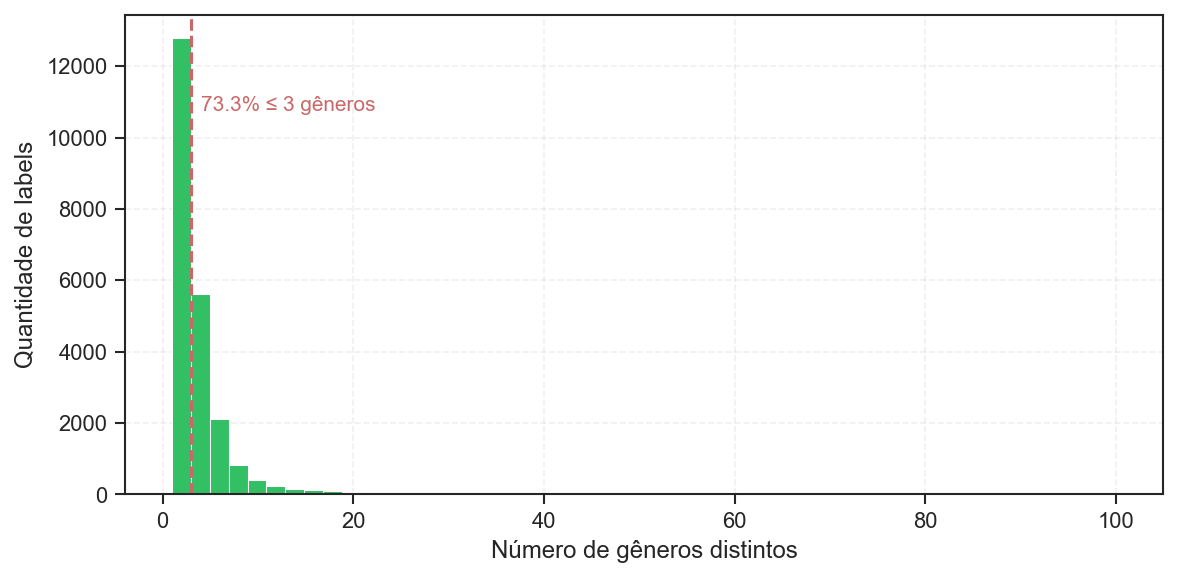

In [24]:
# se tiver listas: ok. se tiver NaN: filtra.
tmp = (train_df
       .loc[:, ["label", "artist_genres"]]
       .explode("artist_genres")
       .dropna(subset=["artist_genres"]))

# garantir string
tmp["artist_genres"] = tmp["artist_genres"].astype(str)

# n gêneros únicos por label
n_gen_por_label = tmp.groupby("label")["artist_genres"].nunique()

# resumo
print(n_gen_por_label.describe())

# Histograma de Gêneros por Label
plt.figure(figsize=(8, 4))
data = n_gen_por_label.clip(upper=100)

# Note o uso de C_PRIMARY e alpha para suavizar
sns.histplot(data, bins=50, color=C_PRIMARY, edgecolor='white', linewidth=0.5, alpha=0.9)

# plt.title("Distribuição de Gêneros por Gravadora")
plt.xlabel("Número de gêneros distintos")
plt.ylabel("Quantidade de labels")

# Linha de destaque minimalista
plt.axvline(3, color=C_HIGHLIGHT, linestyle="--", lw=1.5)
plt.text(4, plt.ylim()[1]*0.8, "73.3% ≤ 3 gêneros", color=C_HIGHLIGHT, fontsize=10)

plt.tight_layout()
plt.show()

In [25]:
#Remoção das variáveis "label" e "total_tracks"

train_df = train_df.drop(columns=["label", "total_tracks"], errors="ignore")
test_df = test_df.drop(columns=["label", "total_tracks"], errors="ignore")

### Interpretação
- Maioria (≈ 73 %) das gravadoras é especializada, atuando em até três gêneros musicais.
- A minoria (≈ 27 %) cobre centenas de gêneros, correspondendo a grandes selos (majors) com catálogos extremamente diversos.
- Essa combinação gera uma distribuição altamente desigual e esparsa, dificultando o uso da variável como preditor estável.

### Implicações para o modelo
- A presença de milhares de labels raras torna a codificação categórica inviável (36 903 valores distintos no conjunto de treinamento).
- O sinal informativo das labels especializadas é diluído pela predominância de grandes gravadoras generalistas.
- Assim, o atributo tende a introduzir ruído e overfitting, sem agregar valor relevante à similaridade musical.

### Conclusão
A variável label foi excluída do conjunto final de features por apresentar alta cardinalidade, baixa consistência semântica e correlação fraca com as dimensões sonoras e de gênero relevantes ao problema de recomendação e cold-start.

## Transformação de atributos e Content Embeddings

In [26]:
train_df.dtypes

track_uri                         object
track_name                        object
artist_uri                        object
artist_name                       object
album_uri                         object
album_name                        object
duration_ms                      float32
pos                              float32
pid                              float32
acousticness                     float32
danceability                     float32
energy                           float32
instrumentalness                 float32
liveness                         float32
loudness                         float32
speechiness                      float32
tempo                            float32
valence                          float32
key                              float32
mode                             float32
artist_followers                 float32
artist_popularity                float32
artist_genres                     object
release_date              datetime64[ns]
release_date_pre

In [27]:
# Listas
numerics = ['acousticness', 'danceability', 'energy', 'instrumentalness', 
            'liveness', 'loudness', 'speechiness', 'tempo', 'valence', 'duration_ms',
            'release_year', "artist_followers"]

categorics = ['key', 'mode', 'album_type'] 

temps = ["artist_popularity", "album_popularity"]

all_features = numerics + categorics

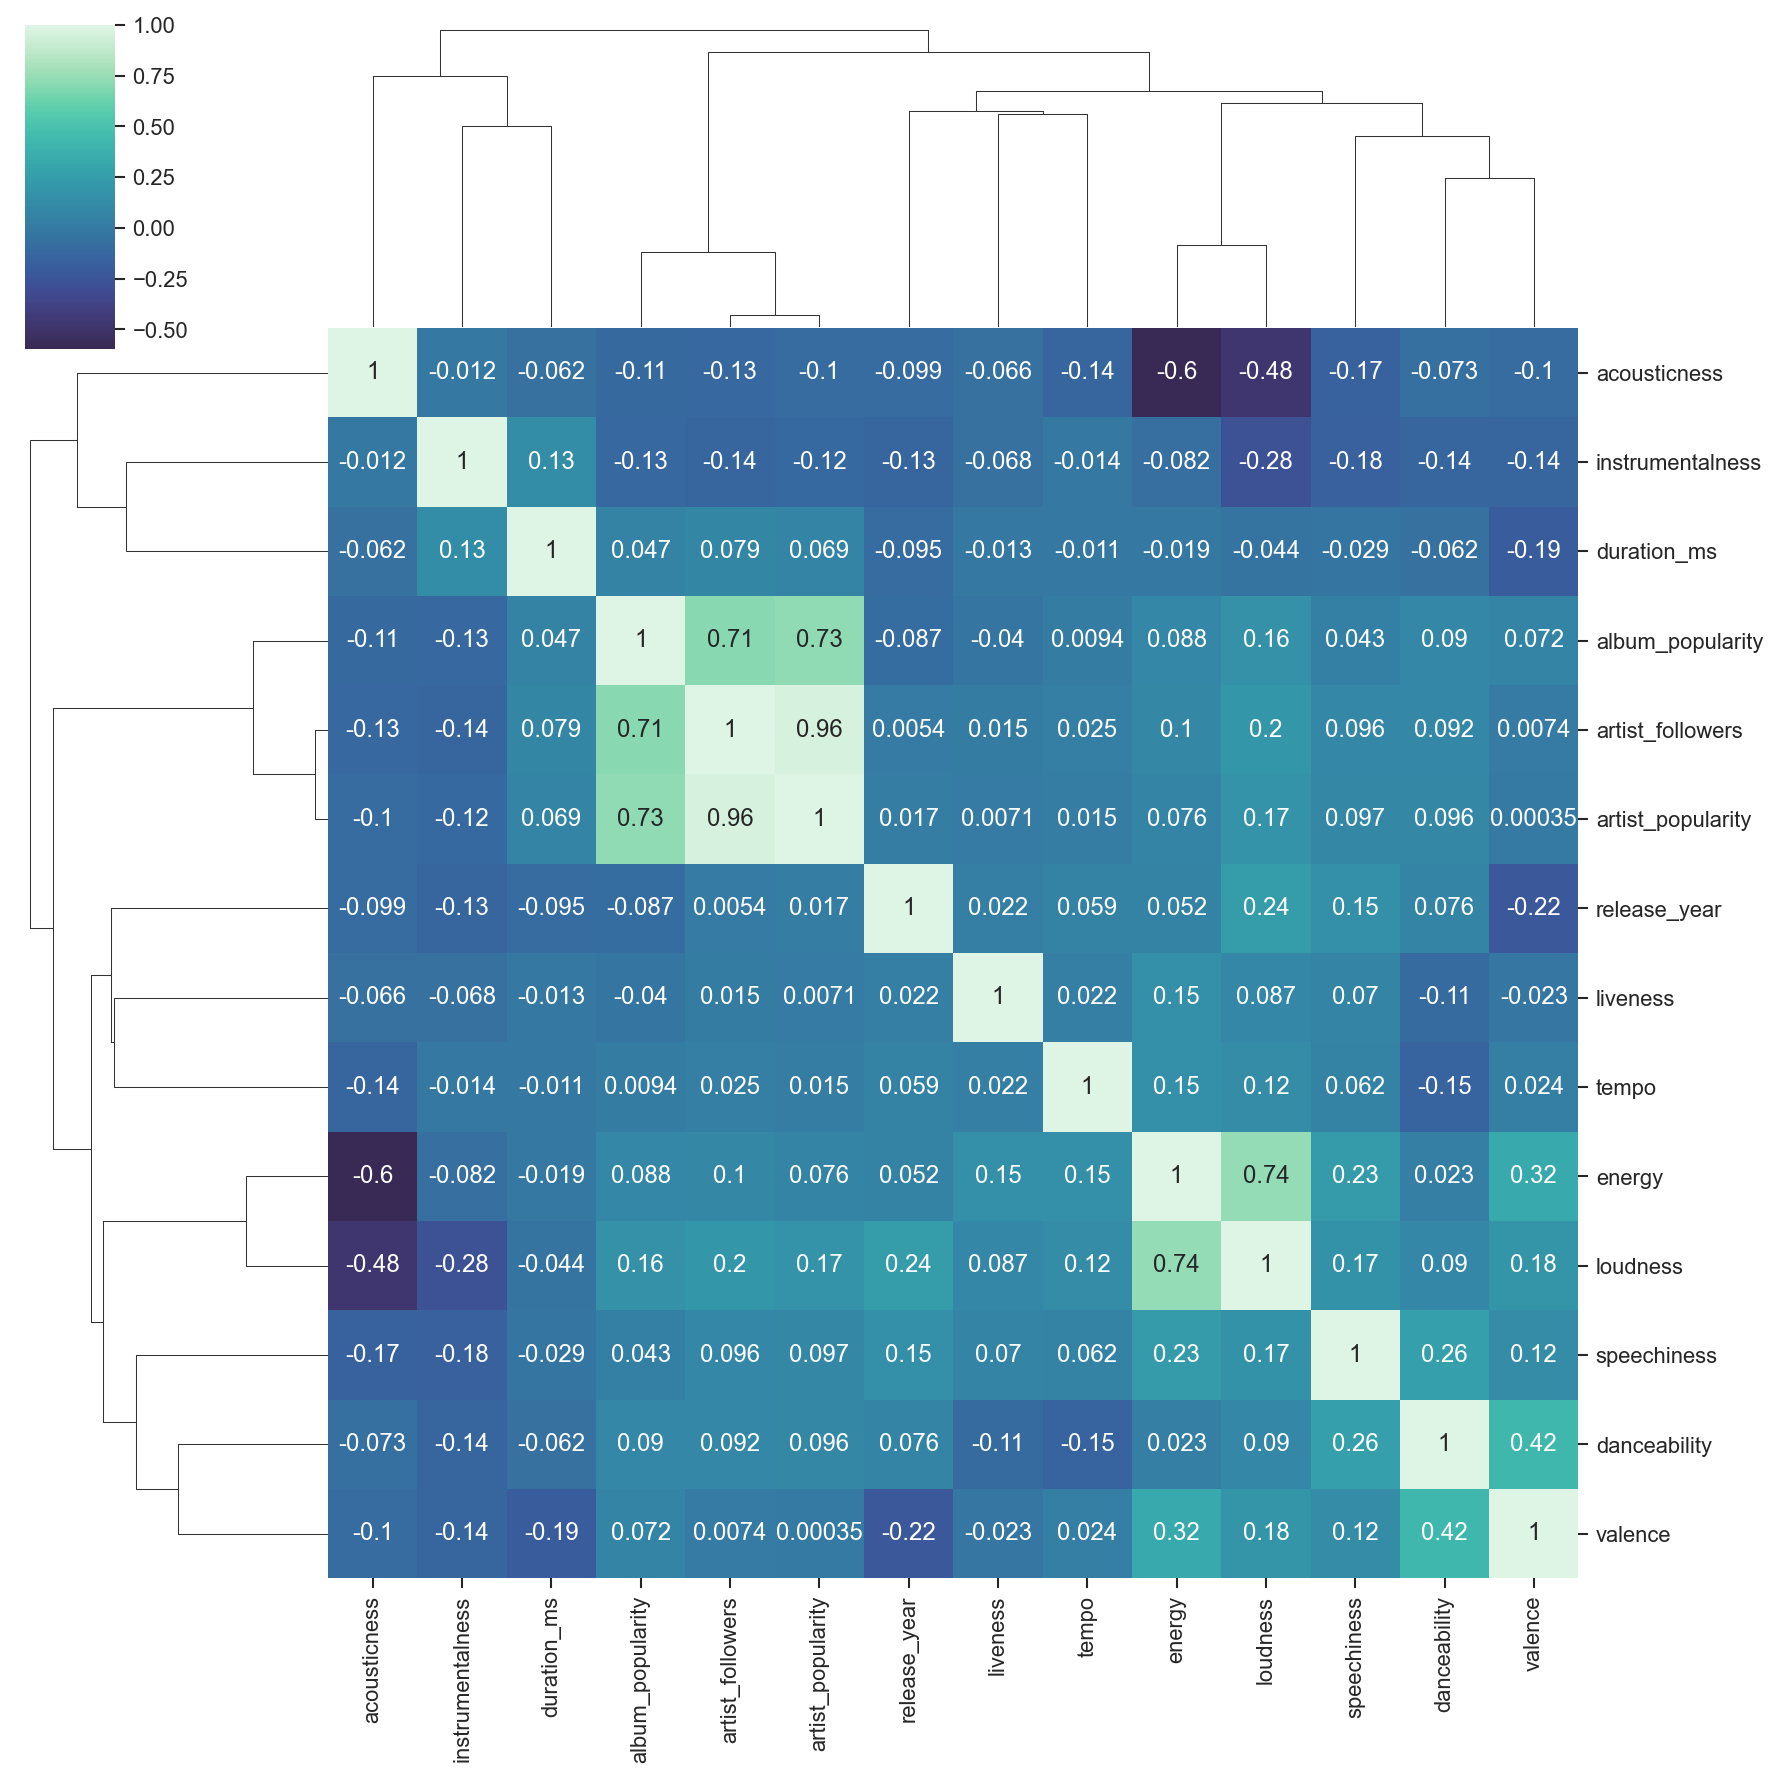

In [28]:
# Mapa de Calor com Agrupamento Hierárquico
corr = train_df[numerics + temps].corr('spearman')
sns.clustermap(
    corr, 
    annot=True, 
    cmap='mako', 
    center=0,
    figsize=(12, 12)
)
plt.show()

In [29]:
#Remoção da variáveis "artist_followers" e "album_popularity"

train_df = train_df.drop(columns=["artist_popularity", "album_popularity"], errors="ignore")
test_df = test_df.drop(columns=["artist_popularity", "album_popularity"], errors="ignore")

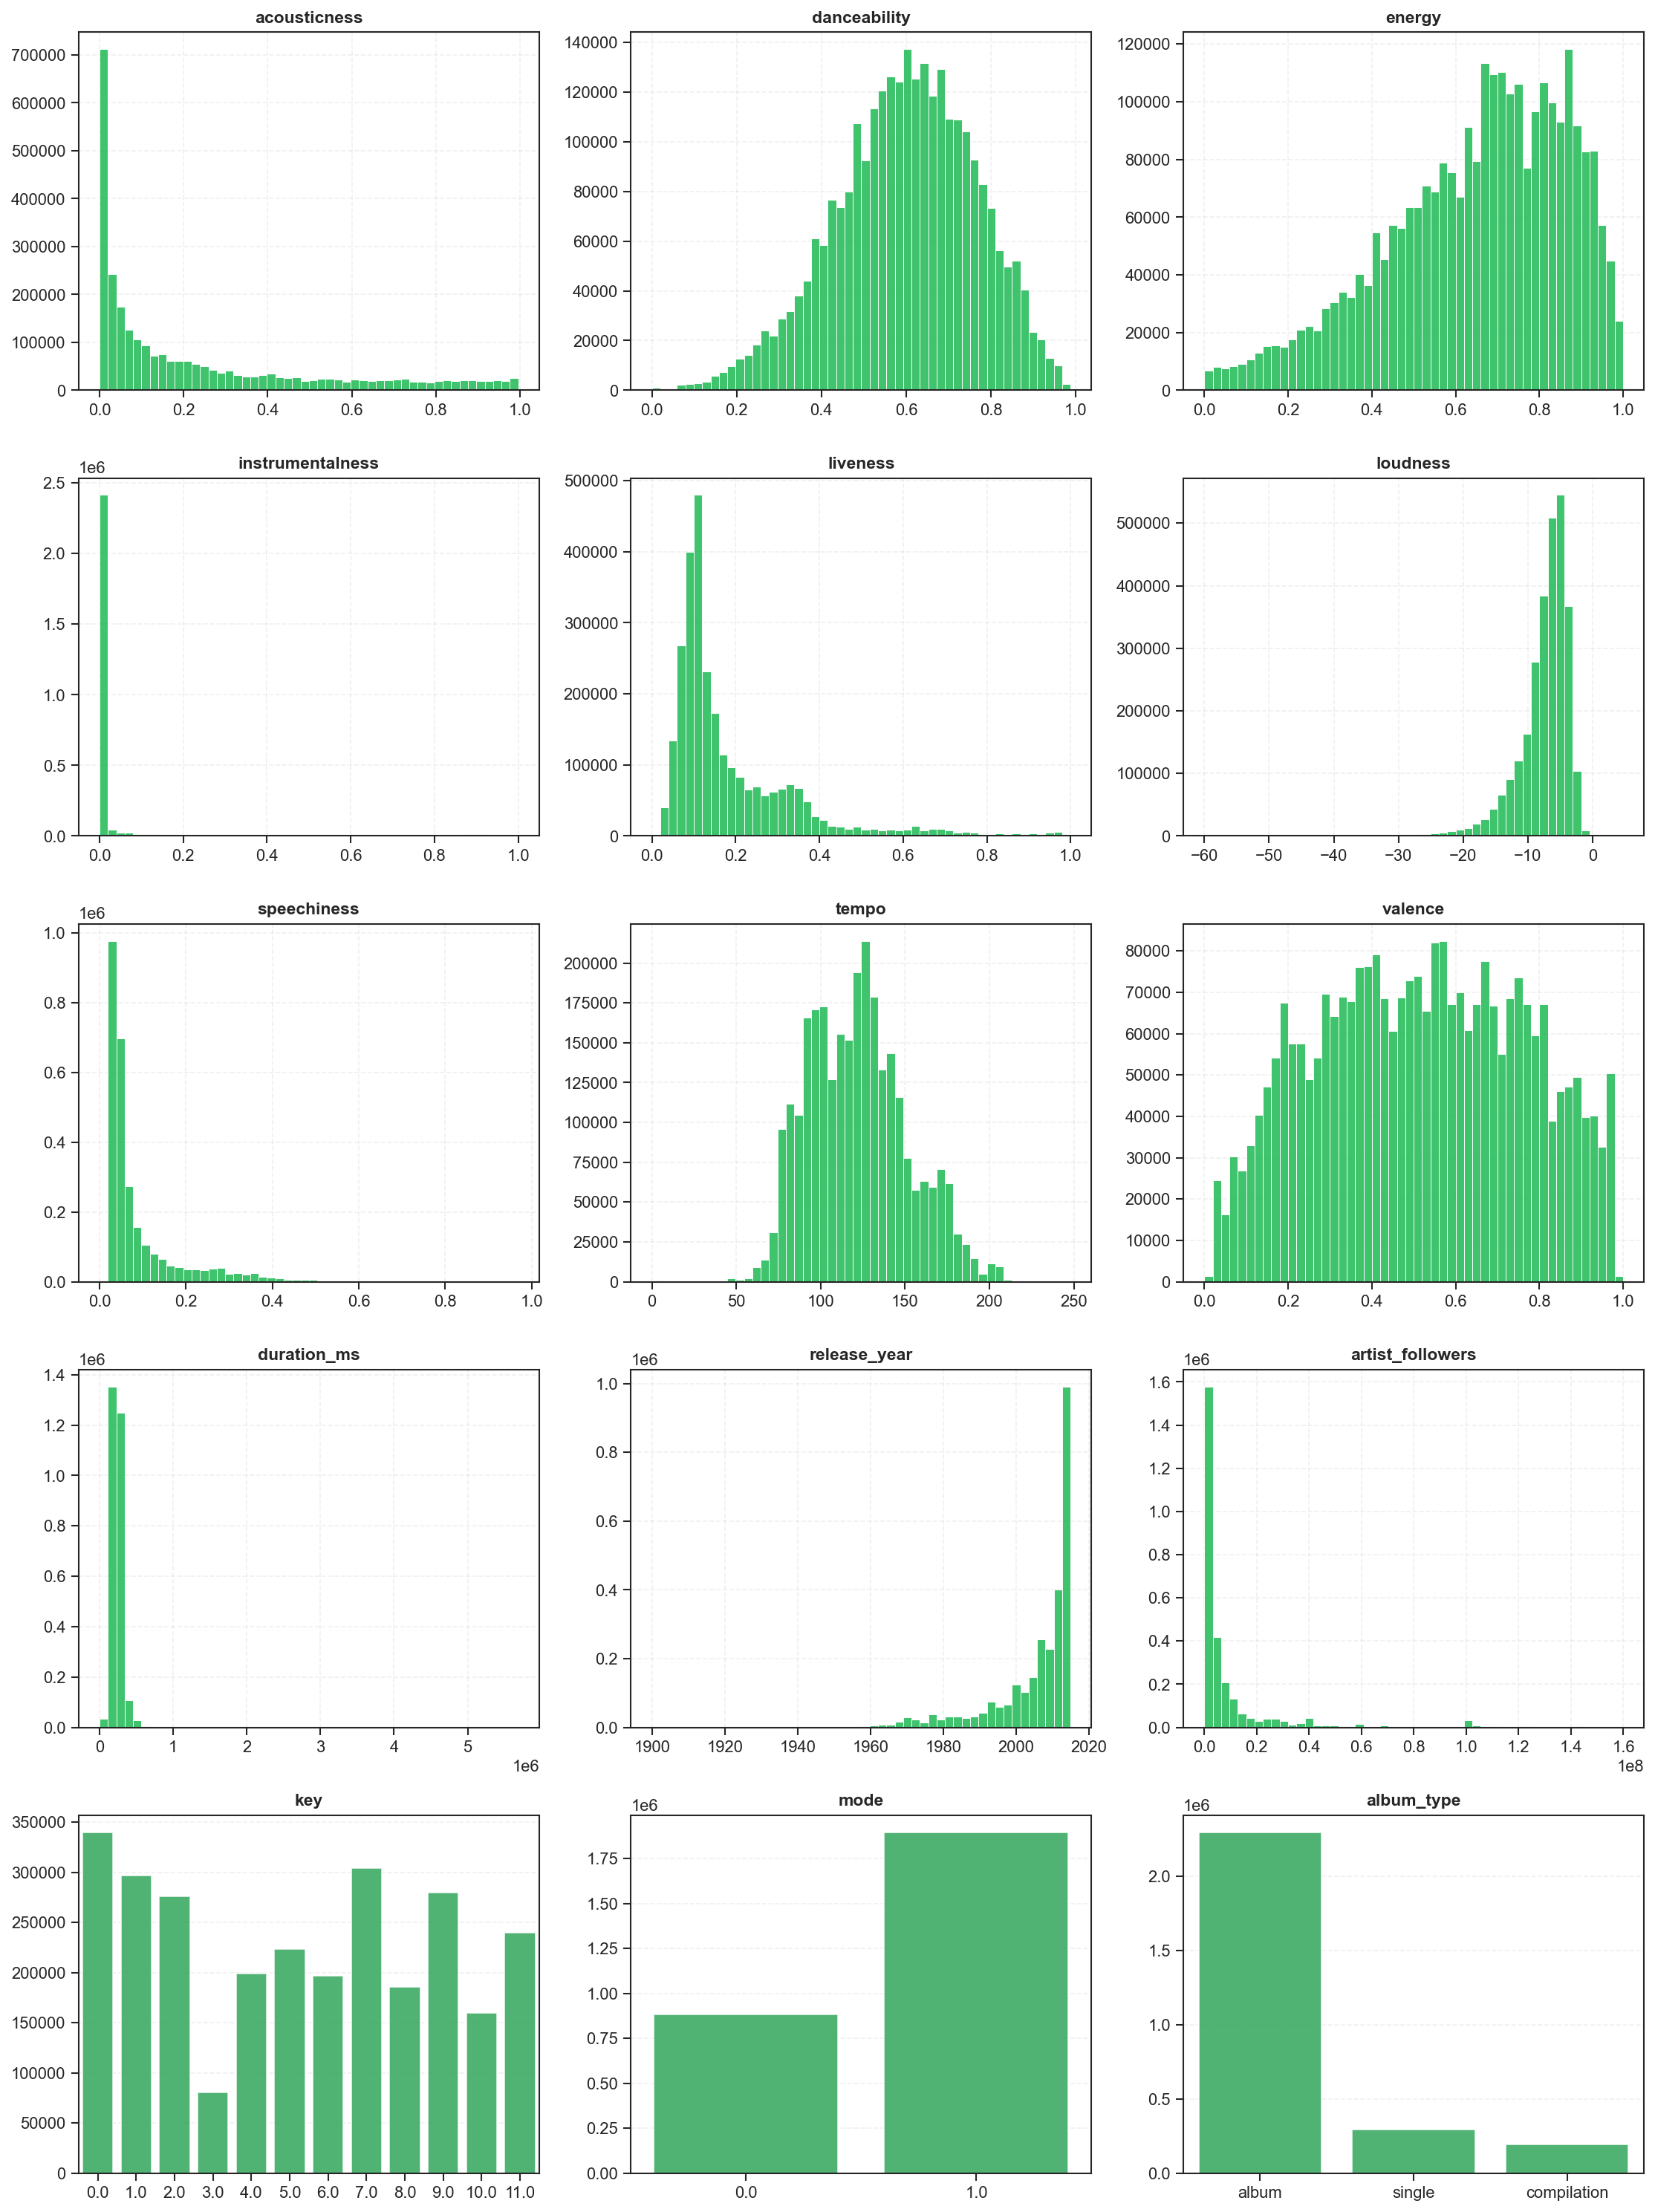

In [30]:
import math
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Definição de cores caso não existam
C_PRIMARY = "#1DB954"  # Verde Spotify
C_HIGHLIGHT = "#191414" 
C_NEUTRAL = "#191414"

cols = 3
rows = math.ceil(len(all_features) / cols)
fig, axes = plt.subplots(rows, cols, figsize=(15, 4 * rows))
axes = axes.ravel()

for i, col in enumerate(all_features):
    if col in train_df.columns:
        ax = axes[i]
        
        # Lógica Diferenciada: Categórico vs Numérico
        if col in categorics:
            sns.countplot(data=train_df, x=col, ax=ax, color=C_PRIMARY, alpha=0.85)
            ax.set_title(f'{col}', fontsize=11, fontweight='bold')
        else:
            # Histograma para numéricos
            sns.histplot(train_df[col], ax=ax, bins=50, color=C_PRIMARY, edgecolor=None, alpha=0.85)
            ax.set_title(f'{col}', fontsize=11, fontweight='bold')

        ax.set_xlabel('')
        ax.set_ylabel('')

# Limpeza de eixos excedentes
for i in range(len(all_features), len(axes)):
    axes[i].set_visible(False)


plt.tight_layout()
plt.show()

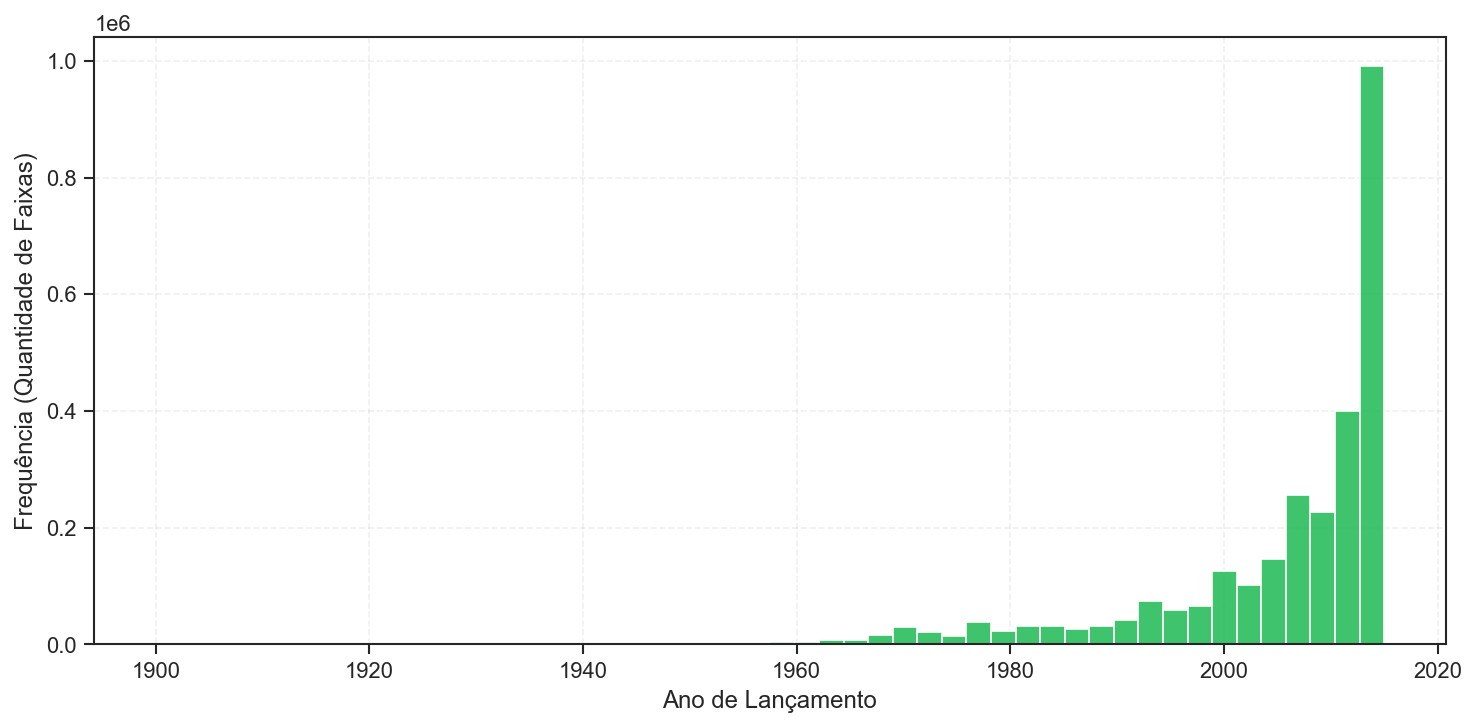

In [32]:
# Configuração da figura
fig, ax = plt.subplots(figsize=(10, 5))

# Distribuição temporal
sns.histplot(
    data=train_df,
    x='release_year',
    bins=50,              
    color="#1DB954",      
    edgecolor=None,      
    alpha=0.85,
    ax=ax
)

# Títulos e Labels
ax.set_xlabel('Ano de Lançamento')
ax.set_ylabel('Frequência (Quantidade de Faixas)')

plt.tight_layout()
plt.show()

### Artists Genres

In [33]:
# colunas de audio features 
AUDIO_COLS = [
    "acousticness", "danceability", "energy", "instrumentalness", "liveness",
    "loudness", "speechiness", "tempo", "valence", "key", "mode"
]

# colunas de “contexto leve”
CONTEXT_NUM = ["release_year","days_since_release"]
CONTEXT_CAT = ["album_type", "label", "total_tracks"]
POP_COLS    = ["artist_followers"] 

In [34]:
from typing import Optional, Dict, Tuple, Any
import numpy as np
import pandas as pd

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import Normalizer

# === HELPERS AJUSTADOS ====================================================

def _genres_to_text(xs):
    if isinstance(xs, (list, tuple, np.ndarray)):
        return " ".join(str(x) for x in xs if pd.notna(x))
    elif pd.notna(xs):
        return str(xs)
    else:
        return ""

def _build_artist_genre_embedding(
    artist_df: pd.DataFrame,
    col_genres: str = "artist_genres",
    col_artist: str = "artist_uri",
    n_components: int = 32,
    min_df: int = 5,
    random_state: int = 42,
    tfidf_model: Optional[TfidfVectorizer] = None,
    svd_model: Optional[TruncatedSVD] = None,
) -> Tuple[pd.DataFrame, TfidfVectorizer, TruncatedSVD]:
    """
    Refatorado: Aceita modelos pré-treinados para garantir consistência.
    """
    adf = artist_df[[col_artist, col_genres]].drop_duplicates(col_artist).set_index(col_artist)
    txt = adf[col_genres].fillna("").apply(_genres_to_text)

    # 1. TF-IDF
    if tfidf_model is None:
        tfidf_model = TfidfVectorizer(min_df=min_df, token_pattern=r"(?u)\b\w[\w+.-]+\b")
        X = tfidf_model.fit_transform(txt)
    else:
        X = tfidf_model.transform(txt)

    # 2. SVD
    if svd_model is None:
        n_comp = min(n_components, max(1, min(X.shape[0], X.shape[1]) - 1))
        svd_model = TruncatedSVD(n_components=n_comp, random_state=random_state)
        X_red = svd_model.fit_transform(X)
    else:
        X_red = svd_model.transform(X)

    # 3. Normalizer 
    norm = Normalizer()
    X_emb = norm.fit_transform(X_red)

    cols = [f"genre_emb_{i:02d}" for i in range(X_red.shape[1])]
    df_emb = pd.DataFrame(X_emb, index=adf.index, columns=cols).astype("float32")
    
    return df_emb, tfidf_model, svd_model

def _hier_impute_mean(df, col, levels=(["artist_uri"], ["album_uri"])):
    s = pd.to_numeric(df[col], errors="coerce")
    out = s.copy()
    for by in levels:
        m = df.groupby(by, dropna=False)[col].transform("mean")
        nan_mask = out.isna()
        out = out.where(~nan_mask, m)
    out = out.fillna(s.mean())
    return out

# === FUNÇÃO PRINCIPAL ===========================================

def build_content_table(
    df_tracks_complete: pd.DataFrame,
    n_genre_components: int = 32,
    min_df_genre: int = 5,
    impute_audio_hier: bool = True,
    album_type2id: Optional[Dict[str, int]] = None,
    genre_models: Optional[Dict[str, Any]] = None, # Dicionário com 'tfidf' e 'svd'
) -> Tuple[pd.DataFrame, Dict[str, int], Dict[str, Any]]:
    """
    Retorna agora (content_df, album_type2id, genre_models)
    """
    required_min = {"track_uri", "artist_uri", "album_uri", "artist_genres"}
    missing = required_min - set(df_tracks_complete.columns)
    if missing:
        raise ValueError(f"Faltam colunas mínimas: {missing}")

    dfu = df_tracks_complete.drop_duplicates("track_uri").copy()

    # --- AUDIO IMPUTATION (Global vars assumidas: AUDIO_COLS, POP_COLS, etc) ---
    audio_all = list(dict.fromkeys(AUDIO_COLS))
    if impute_audio_hier:
        for col in audio_all:
            if col in dfu.columns:
                dfu[col] = _hier_impute_mean(dfu, col)

    # --- NUMÉRICAS E TEMPORAIS ---
    if "duration_ms" in dfu.columns:
        dfu["duration_ms"] = pd.to_numeric(dfu["duration_ms"], errors="coerce").astype("float32")
    if "release_year" in dfu.columns:
        dfu["ctx_release_year"] = pd.to_numeric(dfu["release_year"], errors="coerce").astype("float32")
    if "days_since_release" in dfu.columns:
        dfu["ctx_days_since_release"] = pd.to_numeric(dfu["days_since_release"], errors="coerce").astype("float32")

    # --- POPULARIDADE ---
    pop_cols = POP_COLS.copy()
    if "artist_followers" in dfu.columns and "artist_followers" not in pop_cols:
        pop_cols.append("artist_followers")

    # --- CATEGÓRICAS (ALBUM TYPE) ---
    if "album_type" in dfu.columns:
        album_type_series = dfu["album_type"].fillna("UNK")
        if album_type2id is not None:
            default_unk = album_type2id.get("UNK", 0)
            album_type_id = album_type_series.map(lambda x: album_type2id.get(x, default_unk))
        else:
            album_types = sorted(album_type_series.dropna().unique().tolist())
            if "UNK" not in album_types: album_types = ["UNK"] + album_types
            album_type2id = {cat: i for i, cat in enumerate(album_types)}
            album_type_id = album_type_series.map(album_type2id)
        dfu["ctx_album_type_id"] = album_type_id.fillna(0).astype("int32")

    # --- GENRE EMBEDDINGS  ---
    tfidf_in = genre_models.get('tfidf') if genre_models else None
    svd_in = genre_models.get('svd') if genre_models else None

    GEN_artist, tfidf_out, svd_out = _build_artist_genre_embedding(
        dfu[["artist_uri", "artist_genres"]].drop_duplicates("artist_uri"),
        n_components=n_genre_components,
        min_df=min_df_genre,
        tfidf_model=tfidf_in,
        svd_model=svd_in
    )
    
    # Atualiza dicionário de modelos para retorno
    updated_genre_models = {'tfidf': tfidf_out, 'svd': svd_out}
    dfu = dfu.join(GEN_artist, on="artist_uri")

    # --- SELEÇÃO DE COLUNAS ---
    out_cols = ["track_uri"]
    for c in ["duration_ms", "tempo", "loudness", "ctx_release_year", "ctx_days_since_release"]:
        if c in dfu.columns: out_cols.append(c)
    out_cols += [c for c in audio_all if c in dfu.columns and c not in ["tempo", "loudness"]]
    out_cols += [c for c in pop_cols if c in dfu.columns]
    if "ctx_album_type_id" in dfu.columns: out_cols.append("ctx_album_type_id")
    out_cols += [c for c in dfu.columns if c.startswith("genre_emb_")]

    content = dfu[out_cols].copy()
    
    # Tipagem final (int para ID, float32 para o resto)
    for c in content.columns:
        if c == "track_uri": continue
        if c == "ctx_album_type_id":
            content[c] = content[c].astype("int32")
        else:
            content[c] = pd.to_numeric(content[c], errors="coerce").astype("float32")

    return content, album_type2id, updated_genre_models

In [35]:
# 1. PROCESSAMENTO DE TREINO
content_tbl_train, album_type2id, trained_models = build_content_table(
    train_df,
    n_genre_components=32,
    min_df_genre=5
)

# 2. PROCESSAMENTO DE TESTE (Reutilizando TUDO do treino)
content_tbl_test, _, _ = build_content_table(
    test_df,
    album_type2id=album_type2id,    # Mapeamento de categorias idêntico
    genre_models=trained_models     # TF-IDF e SVD idênticos
)

print(f"Treino: {content_tbl_train.shape}")
print(f"Teste: {content_tbl_test.shape}")

Treino: (324305, 49)
Teste: (60417, 49)


### Encoding de Variáveis Categóricas (Otimização)

In [36]:
print("Aplicando encoding otimizado de features categóricas...")

def apply_categorical_encoding(df):
    df_enc = df.copy()
    
    # 1. Circular Encoding para Key (12 notas musicais)
    if "key" in df_enc.columns:
        df_enc["key_sin"] = np.sin(2 * np.pi * df_enc["key"] / 12)
        df_enc["key_cos"] = np.cos(2 * np.pi * df_enc["key"] / 12)
        df_enc = df_enc.drop(columns=["key"])
        print(f"   ✓ Circular encoding aplicado em 'key' (→ key_sin, key_cos)")
    
    # 2. One-Hot Encoding para ctx_album_type_id
    if "ctx_album_type_id" in df_enc.columns:
        album_type_dummies = pd.get_dummies(df_enc["ctx_album_type_id"], prefix="album_type")
        # Remove uma coluna para evitar colinearidade (dummy variable trap)
        album_type_dummies = album_type_dummies.astype("float32")
        df_enc = pd.concat([df_enc, album_type_dummies], axis=1)
        df_enc = df_enc.drop(columns=["ctx_album_type_id"])
        print(f"   ✓ One-hot encoding aplicado em 'ctx_album_type_id' (→ {len(album_type_dummies.columns)} colunas)")
    
    return df_enc

# Aplicar em treino e teste
content_tbl_train = apply_categorical_encoding(content_tbl_train)
content_tbl_test = apply_categorical_encoding(content_tbl_test)

print(f"\nShape após encoding:")
print(f"  Train: {content_tbl_train.shape}")
print(f"  Test:  {content_tbl_test.shape}")

Aplicando encoding otimizado de features categóricas...
   ✓ Circular encoding aplicado em 'key' (→ key_sin, key_cos)
   ✓ One-hot encoding aplicado em 'ctx_album_type_id' (→ 3 colunas)
   ✓ Circular encoding aplicado em 'key' (→ key_sin, key_cos)
   ✓ One-hot encoding aplicado em 'ctx_album_type_id' (→ 3 colunas)

Shape após encoding:
  Train: (324305, 52)
  Test:  (60417, 52)


In [37]:
track_ids_train = content_tbl_train["track_uri"].reset_index(drop=True)
track_ids_test  = content_tbl_test["track_uri"].reset_index(drop=True)

In [38]:
track_ids_train.shape, track_ids_test.shape

((324305,), (60417,))

### Normalizar

In [39]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, RobustScaler
from joblib import dump

# colunas para padronização
# Nota: 'key' foi removida e substituída por 'key_sin' e 'key_cos'
STD_COLS = ["duration_ms", "tempo", "loudness", "ctx_release_year", "ctx_days_since_release", "key_sin", "key_cos"]
ROB_COLS = ["artist_followers"]

pre = ColumnTransformer(
    transformers=[
        ('std', StandardScaler(), [c for c in STD_COLS if c in content_tbl_train.columns]),
        ('rob', RobustScaler(quantile_range=(25, 75)), [c for c in ROB_COLS if c in content_tbl_train.columns]),
    ],
    remainder='passthrough',
    verbose_feature_names_out=False
)
pre.set_output(transform="pandas")

# treino do pré-processador no TRAIN
pre.fit(content_tbl_train.drop(columns=['track_uri']))

model_path = BASE_DIR / "conf/pre_S2.joblib"

X_train = pre.transform(content_tbl_train.drop(columns=['track_uri'])).reset_index(drop=True)
X_test  = pre.transform(content_tbl_test.drop(columns=['track_uri'])).reset_index(drop=True)

In [40]:
X_train_df = pd.concat([track_ids_train, X_train], axis=1)
X_test_df  = pd.concat([track_ids_test, X_test], axis=1)

In [41]:
X_train_df.shape, X_test_df.shape

((324305, 52), (60417, 52))

In [42]:
# Salvar usando o caminho dinâmico do YAML
df_tracks_complete_v5 = df_tracks_complete_v5.drop(columns=["artist_popularity", "album_popularity"], errors="ignore")
save_path = P['interim'] / "df_tracks_complete_v5.parquet"

df_tracks_complete_v5.to_parquet(save_path, index=False)

print(f"Salvo em: {save_path}")

Salvo em: /Users/lucasborges/Downloads/TCC/data/interim/df_tracks_complete_v5.parquet


In [43]:
# Salvar X_train
save_path_train = P['processed'] / F['train_features']
X_train_df.to_parquet(save_path_train, index=False)
print(f"X_train salvo em: {save_path_train}")

# Salvar X_test
save_path_test = P['processed'] / F['test_features']
X_test_df.to_parquet(save_path_test, index=False)
print(f"X_test salvo em: {save_path_test}")

X_train salvo em: /Users/lucasborges/Downloads/TCC/data/processed/train_features_v2.parquet
X_test salvo em: /Users/lucasborges/Downloads/TCC/data/processed/test_features_v2.parquet


In [44]:
track_feats_train = content_tbl_train.copy()
track_feats_test  = content_tbl_test.copy()

In [45]:
# Salvar content_tbl_train
content_tbl_train.to_parquet(P['interim'] / "content_ctx_train.parquet", index=False)

# Salvar content_tbl_test
content_tbl_test.to_parquet(P['interim'] / "content_ctx_test.parquet", index=False)

In [46]:
def quantify_cold_start(train_df: pd.DataFrame, test_df: pd.DataFrame):
    # 1. Conjuntos de IDs únicos
    artists_train = set(train_df['artist_uri'].unique())
    artists_test = set(test_df['artist_uri'].unique())
    
    # 2. Identificar interseção e novos
    artists_new = artists_test - artists_train
    artists_common = artists_test.intersection(artists_train)
    
    # 3. Quantificar faixas afetadas
    tracks_cold_artist = test_df[test_df['artist_uri'].isin(artists_new)].shape[0]
    tracks_warm_artist = test_df[test_df['artist_uri'].isin(artists_common)].shape[0]
    
    print("=== ANÁLISE DE COLD-START (Artistas) ===")
    print(f"Artistas no Treino: {len(artists_train):,}")
    print(f"Artistas no Teste:  {len(artists_test):,}")
    print(f"Novos Artistas (Cold): {len(artists_new):,} ({len(artists_new)/len(artists_test):.2%})")
    print("-" * 40)
    print(f"Músicas no Teste de artistas CONHECIDOS: {tracks_warm_artist:,} ({tracks_warm_artist/len(test_df):.2%})")
    print(f"Músicas no Teste de artistas NOVOS (Cold): {tracks_cold_artist:,} ({tracks_cold_artist/len(test_df):.2%})")
    
    return artists_new

# Executar a análise
cold_artists_list = quantify_cold_start(train_df, test_df)

=== ANÁLISE DE COLD-START (Artistas) ===
Artistas no Treino: 62,818
Artistas no Teste:  20,443
Novos Artistas (Cold): 12,032 (58.86%)
----------------------------------------
Músicas no Teste de artistas CONHECIDOS: 702,637 (82.22%)
Músicas no Teste de artistas NOVOS (Cold): 151,912 (17.78%)


Gerando Figura: Distribuição Long Tail...
   ✓ 3,636,571 registros carregados
   ✓ Salvo em: /Users/lucasborges/Downloads/TCC/reports/figures/long_tail_boosted.png


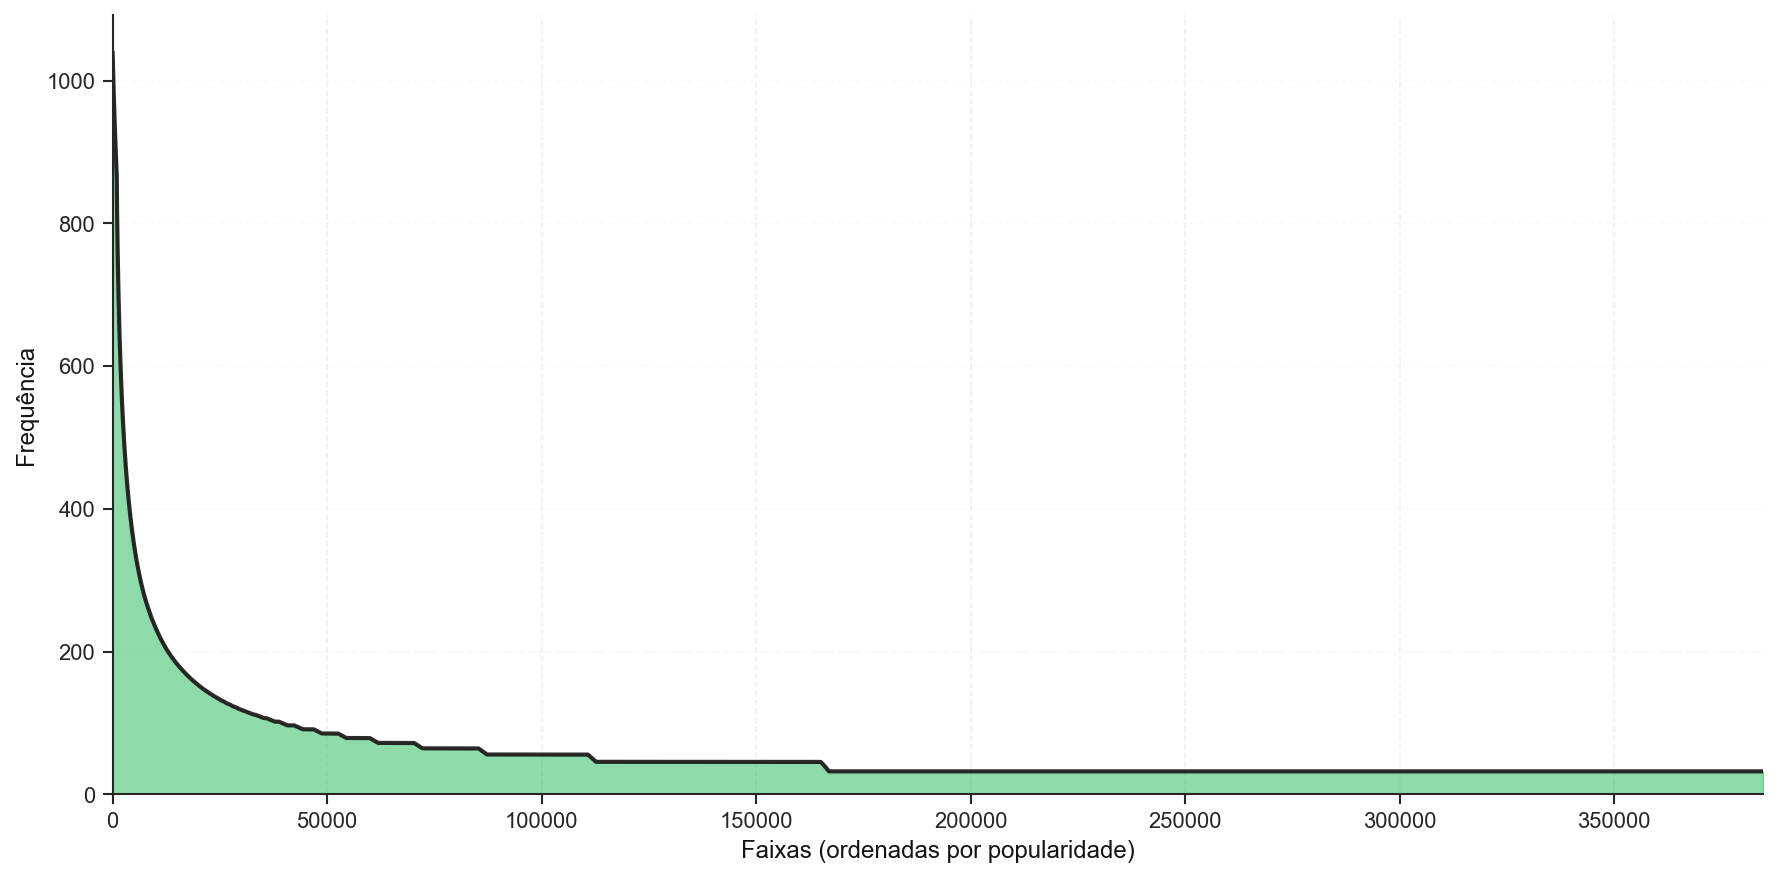

In [47]:
# ==============================================================================
# VISUALIZAÇÃO: Distribuição de Interações por Música (Long Tail)
# ==============================================================================
# Objetivo: Mostrar a distribuição de frequência das músicas nas playlists,
# demonstrando o fenômeno de cauda longa (long tail).

def plot_long_tail_boosted(save_name="long_tail_boosted.png"):
    """
    Gera visualização da distribuição Long Tail das músicas.
    Carrega dados automaticamente de df_tracks_complete_v5.parquet
    """
    print("Gerando Figura: Distribuição Long Tail...")
    
    # Carregar dados
    tracks_path = P['interim'] / "df_tracks_complete_v5.parquet"
    if not tracks_path.exists():
        print(f"   ⚠️ Arquivo não encontrado: {tracks_path}")
        return
    
    df = pd.read_parquet(tracks_path)
    print(f"   ✓ {len(df):,} registros carregados")
    
    # Contagem de frequência por música
    counts = df['track_uri'].value_counts().values
    x = np.arange(len(counts))
    
    # Suavização para evitar serrilhado
    counts_smoothed = pd.Series(counts).rolling(
        window=max(1, len(counts)//200), 
        min_periods=1, 
        center=True
    ).mean().values
    
    # Boost visual (compressão de escala)
    exponent = 0.5 
    counts_visual = np.power(counts_smoothed, exponent)
    counts_visual = (counts_visual / counts_visual.max()) * counts_smoothed.max()
    
    # Plot
    plt.figure(figsize=(12, 6))
    plt.fill_between(x, counts_visual, color=C_PRIMARY, alpha=0.5, label='Volume (Visual Boost)')
    plt.plot(x, counts_visual, color=C_NEUTRAL, linewidth=2, alpha=0.9)
    
    plt.xlabel('Faixas (ordenadas por popularidade)', color=C_NEUTRAL)
    plt.ylabel('Frequência', color=C_NEUTRAL)
    
    sns.despine()
    plt.grid(axis='y', alpha=0.1, linestyle='--')
    plt.xlim(0, len(counts))
    plt.ylim(0, counts_smoothed.max() * 1.05) 
    plt.tight_layout()
    
    # Salvar
    save_path = P['figures'] / save_name
    save_path.parent.mkdir(parents=True, exist_ok=True)
    plt.savefig(save_path, dpi=300, bbox_inches='tight', format='png')
    print(f"   ✓ Salvo em: {save_path}")
    plt.show()

# Executar
plot_long_tail_boosted()